In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import sklearn.linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from scipy.stats import expon, reciprocal, randint
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelBinarizer

In [4]:
x_train = pd.read_csv("/kaggle/input/titanic/train.csv")
x_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
# maybe do fillna instead
# keep in mind missing values of test set must be filled in as well then
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
y_train = x_train['Survived'].copy()

In [7]:
x_train.drop(['Name','Embarked', 'Cabin','Survived'], axis=1,inplace=True)
x_test.drop(['Name','Embarked', 'Cabin'], axis=1,inplace=True)

In [8]:
x_train.drop(['Ticket'], axis=1,inplace=True)
x_test.drop(['Ticket'], axis=1,inplace=True)

In [9]:
x_train['Family'] = x_train['SibSp']+x_train['Parch']
x_train.drop(['SibSp','Parch'],axis=1,inplace=True)
x_test['Family'] = x_test['SibSp']+x_test['Parch']
x_test.drop(['SibSp','Parch'],axis=1,inplace=True)

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Fare         891 non-null    float64
 5   Family       891 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 41.9+ KB


In [11]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
    
])

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])
num_attribs = list(x_train.select_dtypes(exclude=['object']))
cat_attribs = list(x_train.select_dtypes(include=['object']))

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])
titanic_prep = full_pipeline.fit_transform(x_train)

In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Fare         891 non-null    float64
 5   Family       891 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 41.9+ KB


In [13]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [14]:
train_survivors = (y_train == 1)
train_survivors

0      False
1       True
2       True
3       True
4      False
       ...  
886    False
887     True
888    False
889     True
890    False
Name: Survived, Length: 891, dtype: bool

In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(titanic_prep, train_survivors)

SGDClassifier(random_state=42)

In [16]:
cross_val_score(sgd_clf, titanic_prep, train_survivors, cv=3, scoring='accuracy')

array([0.79124579, 0.78787879, 0.7979798 ])

In [17]:
sum = 0
for x in cross_val_score(sgd_clf, titanic_prep, train_survivors, cv=3, scoring='accuracy'):
    sum+= x
sum/3

0.7923681257014591

In [18]:
y_train_pred= cross_val_predict(sgd_clf, titanic_prep, train_survivors, cv=3)

In [19]:
confusion_matrix(train_survivors, y_train_pred)

array([[463,  86],
       [ 99, 243]])

In [20]:
class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
n5_clf = Never0Classifier()
cross_val_score(n5_clf, titanic_prep, train_survivors, cv=3, scoring='accuracy')

array([0.64309764, 0.56902357, 0.63636364])

In [21]:
sum = 0
for x in cross_val_score(n5_clf, titanic_prep, train_survivors, cv=3, scoring='accuracy'):
    sum+= x
sum/3

0.616161616161616

In [22]:
# Maybe add a attribute called Family by combining 'Parch' and 'SibSp'
# Do Feature Scaling by making transformation pipelines with StandardScaler, SimpleImputer, CombinedAttributesAdder
# ColumnTranformer should have num_pipeline and One

In [23]:
x_train

,PassengerId,Pclass,Sex,Age,Fare,Family
0,1,3,male,22.0,7.2500,1
1,2,1,female,38.0,71.2833,1
2,3,3,female,26.0,7.9250,0
3,4,1,female,35.0,53.1000,1
4,5,3,male,35.0,8.0500,0
...,...,...,...,...,...,...
886,887,2,male,27.0,13.0000,0
887,888,1,female,19.0,30.0000,0
888,889,3,female,NaN,23.4500,3
889,890,1,male,26.0,30.0000,0


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train, y_train_pred)

0.7386018237082067

In [25]:
recall_score(y_train,y_train_pred)

0.7105263157894737

In [26]:
f1_score(y_train,y_train_pred)

0.7242921013412816

In [27]:
y_scores = cross_val_predict(sgd_clf, titanic_prep, y_train, cv=3, method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

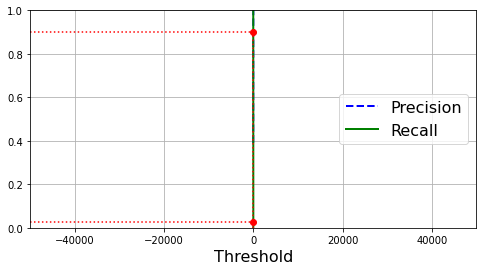

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

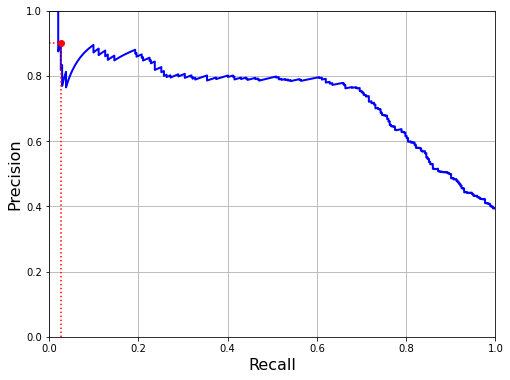

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [32]:
roc_auc_score(y_train, y_scores)

0.81719021293367

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)       

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, titanic_prep, y_train, cv=3, method='predict_proba')

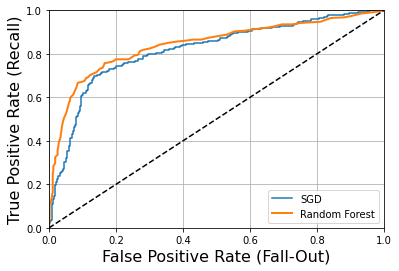

In [35]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)
plt.plot(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend()
plt.show()

In [36]:
roc_auc_score(y_train, y_scores_forest)

0.8421824902267813

In [37]:
y_train_pred_forest = cross_val_predict(forest_clf, titanic_prep, train_survivors, cv=3)

In [38]:
conf_mx = confusion_matrix(y_train, y_train_pred_forest)

In [39]:
conf_mx

array([[480,  69],
       [101, 241]])

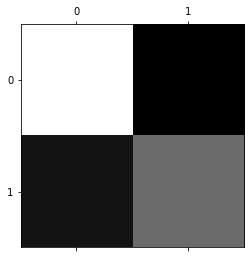

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

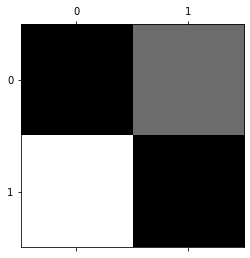

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [42]:
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [43]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootrap = [True, False]
criterion = ['gini','entropy']

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'criterion' : criterion
}

In [44]:
rf_clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_clf, 
                               param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(titanic_prep, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.4s


[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, criterion=entropy 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, criterion=entropy, total=   2.5s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini, total=   1.0s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini, total=   1.0s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=gini, total=   1.7s
[CV] n_estimators=1900

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min


[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, criterion=entropy 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, criterion=entropy, total=   4.3s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini, total=   1.0s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=gini, total=   1.8s
[CV] n_estimators=1900, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini 
[CV]  n_estimators=1900, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini, total=   6.7s
[CV] n_estimators=17

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,


In [45]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'criterion': 'gini'}

In [46]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [47]:
base = RandomForestClassifier()
base.fit(titanic_prep, y_train)
base_accuracy = evaluate(base, titanic_prep, y_train)

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.


In [48]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, titanic_prep, y_train)

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.


In [49]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'criterion': 'gini'}

In [50]:
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [70, 80, 90],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [2,3, 4],
    'min_samples_split': [2,3,4],
    'n_estimators': [1800, 1900, 2000],
    'criterion':['entropy']
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(titanic_prep, y_train)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, criterion=entropy, total=   1.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=entropy, total=   3.6s
[CV] n_estimators=1900, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, criterion=entropy 
[CV]  n_estimators=1900, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, criterion=entropy, total=   6.8s
[CV] n_estimators=900, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, criterion=entropy 
[CV]  n_estimators=900, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, criterion=entropy, total=   3.2s
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy 
[

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.2s



[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy, total=   0.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy, total=   0.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, criterion=entropy, total=   0.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=entropy 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=entropy, total=   1.4s
[CV

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min



[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=   7.2s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=3, n_estimators=1800, total=   6.1s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=3, n_estimators=1900 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=3, n_estimators=1900, total=   6.4s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=4, min_samples_split=4, n_estimators=1800, total=   6.0s
[CV] bootstrap=True, criterio

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 10.2min



[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=1900, total=   7.0s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=3, n_estimators=1800, total=   6.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=3, n_estimators=1900 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=3, n_estimators=1900, total=   6.5s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=3, n_estimators=2000, total=   6.9s
[CV] bootstrap=True, criterio

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 18.3min



[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=2, n_estimators=1800, total=   6.2s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=2, n_estimators=1900 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=2, n_estimators=1900, total=   6.3s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, total=   6.7s
[CV] bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=3, n_estimators=1900 
[CV]  bootstrap=True, criterion=entropy, max_depth=90, max_features=1, min_samples_leaf=4, min_samples_split=3, n_estimators=1900, total=   6.3s
[CV] bootstrap=True, criterio

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 27.9min



[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=3, n_estimators=1800, total=   6.5s
[CV] bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=3, n_estimators=1900 
[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=3, n_estimators=1900, total=   6.8s
[CV] bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=1800, total=   6.7s
[CV] bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=1900 
[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=1900, total=   6.7s
[CV] bootstrap=False, 

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed: 39.5min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'criterion': ['entropy'],
                         'max_depth': [70, 80, 90], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [1800, 1900, 2000]},
             verbose=2)

In [51]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 70,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [52]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(base, titanic_prep, y_train)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.
Improvement of 0.00%.


In [53]:
rf_clf = RandomForestClassifier()
evaluate(base, titanic_prep, y_train)

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.


100.0

In [54]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Fare         891 non-null    float64
 5   Family       891 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 41.9+ KB


In [55]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=70, max_features=3,
                       min_samples_leaf=2, n_estimators=2000)

In [56]:
x_test

,PassengerId,Pclass,Sex,Age,Fare,Family
0,892,3,male,34.5,7.8292,0
1,893,3,female,47.0,7.0000,1
2,894,2,male,62.0,9.6875,0
3,895,3,male,27.0,8.6625,0
4,896,3,female,22.0,12.2875,2
...,...,...,...,...,...,...
413,1305,3,male,NaN,8.0500,0
414,1306,1,female,39.0,108.9000,0
415,1307,3,male,38.5,7.2500,0
416,1308,3,male,NaN,8.0500,0


In [57]:
final_model = grid_search.best_estimator_
x_test_prepared = full_pipeline.transform(x_test)
final_model.fit(titanic_prep, y_train)
final_predictions = final_model.predict(x_test_prepared)
final_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [58]:
pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [59]:
test_ID = x_test['PassengerId']
sub = pd.DataFrame({'PassengerId':test_ID,'Survived':final_predictions})
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [60]:
sub.to_csv('submission.csv', index=False)